In [1]:
import poetrytools as pt
from poetrytools import guess_metre, tokenize, count_syllables
import gzip, json
import random
import pandas as pd
from tqdm.notebook import tqdm
from time import sleep
import matplotlib.pyplot as plt
import pronouncing
from collections import defaultdict
import re

# Frakenpoem Demo

## Get the data 

Use the data provided by [Allison Parrish's repo](https://github.com/aparrish/gutenberg-poetry-corpus/blob/master/quick-experiments.ipynb) and code to unpack json. 

The goal: we want a dataframe which has the lines, the number of syllables the line has, and the meter of the line.

In [168]:
import gzip, json
data = []
for line in gzip.open("gutenberg-poetry-v001.ndjson.gz"):
    data.append(json.loads(line.strip()))

In [169]:
# 3 million lines of poetry data
len(data)

3085117

In [170]:
# a sample
indexes = [random.randint(1, 3000000) for i in range(5)]
for i in range(len(indexes)):
    print(data[indexes[i]]['s'], '\n')

It dies upon her heart, 

presentable. But men of sense know better than so to waste 

Our only playmates little fears-- 

Dazzling command and rich dominion, 

Tempers the fates of human race above; 



In [171]:
df = pd.DataFrame(data)
df = df.rename({'s':'text'}, axis = 'columns')
df = df.drop(['gid'], axis = 1)
df.head()

text
0  The Song of Hiawatha is based on the legends a...
1  many North American Indian tribes, but especia...
2  Ojibway Indians of northern Michigan, Wisconsi...
3  They were collected by Henry Rowe Schoolcraft,...
4  Schoolcraft married Jane, O-bah-bahm-wawa-ge-z...

In [172]:
meters = []
syllables = []
# for i in tqdm(range(len(df))):
#     sleep(0.01)
#     meters.append(guess_metre(tokenize(df.text[i]))[3])
#     syllables.append(count_syllables(df.text[i]))
tqdm.pandas(desc="progress")

def get_meters(x):
    try:
        return guess_metre(tokenize(x))[3]
    except:
        return "null"
    
def get_syllables(x):
    try:
        return count_syllables(x)
    except:
        return "null"

df['meter'] = df['text'].progress_apply(lambda x: get_meters(x))
df['syllables'] = df['text'].progress_apply(lambda x: get_syllables(x))

/Users/211540/Library/Python/3.7/lib/python/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [173]:
print("percentage of null meters: ", len(df[df.meter=="null"])/len(df))
print("percentage of null syllables: ", len(df[df.syllables=="null"])/len(df))

percentage of null meters:  0.00022981300222973716
percentage of null syllables:  0.0


/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [174]:
df.head()

text                meter  \
0  The Song of Hiawatha is based on the legends a...      iambic trimeter   
1  many North American Indian tribes, but especia...  trochaic tetrameter   
2  Ojibway Indians of northern Michigan, Wisconsi...  trochaic tetrameter   
3  They were collected by Henry Rowe Schoolcraft,...  trochaic tetrameter   
4  Schoolcraft married Jane, O-bah-bahm-wawa-ge-z...      iambic trimeter   

   syllables  
0         17  
1         19  
2         19  
3         17  
4         15

In [213]:
df.groupby(['meter']).count()

text  syllables
meter                                 
iambic pentameter    599160     599160
iambic tetrameter    393476     393476
iambic trimeter      891370     891370
null                    709        709
trochaic pentameter  253590     253590
trochaic tetrameter  946812     946812

[]

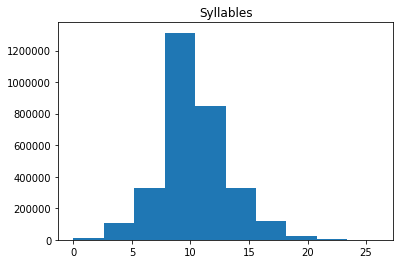

In [190]:
plt.hist(df.syllables)
plt.title("Syllables")
plt.plot()

In [427]:
df.to_pickle("data.pkl.compress", compression="gzip")

## Creation of Frankenbot and the Frankenpoems

The basic poem-generating structure will be:
1. Define hyperparameters for the structure of the poem (length/ number of line breaks)
2. Define helper functions:
    - Get the last word of a line. This will be helpful when we need rhymes later on.
    - Pick the first line of the poem. It's like the "seed line" which will determine the meter and general line length of the poem. 
    - Helper function which will create a rhyme dictionary data structure exactly like the one that Allison Parrish does (here)[https://github.com/aparrish/gutenberg-poetry-corpus/blob/master/quick-experiments.ipynb]
3. Write the poem
    - Each line and whether there is a line break is essentially determined randomly by "a roll of the dice" 
    - Sometimes the rhyme scheme will shift and a "new seed" is planted

In [2]:
df = pd.read_pickle("data.pkl.compress", compression="gzip")

In [10]:
def define_structure():
    length = random.randint(4, 10)
    line_breaks = random.randint(1, length-1)
    return length, line_breaks

def get_last_word(line):
    match = re.search(r'(\b\w+\b)\W*$', line)
    if match:
        last_word = match.group()
    last_word = re.sub(r'[^\w\s]', '', last_word)
    return last_word

def pick_first_line(df):
    last_word = ""
    while last_word == "":
        index = random.randint(1, len(df))
        first_line = df.text[index]
        last_word = get_last_word(first_line)
    return (index, df.text[index], last_word)

def get_rhyme_dict(pruned_df):
    by_rhyming_part = defaultdict(lambda: defaultdict(list))
    for line in tqdm(pruned_df.text):
        match = re.search(r'(\b\w+\b)\W*$', line)
        if match:
            last_word = match.group()
            pronunciations = pronouncing.phones_for_word(last_word)
            if len(pronunciations) > 0:
                rhyming_part = pronouncing.rhyming_part(pronunciations[0])
                # group by rhyming phones (for rhymes) and words (to avoid duplicate words)
                by_rhyming_part[rhyming_part][last_word.lower()].append(line)     
    return by_rhyming_part

def write_poem(df):
    length, line_breaks = define_structure()
    
    # pick the first line and get the last word of that first line
    index, first_line, last_word = pick_first_line(df)
            
    # prune the dataframe so that we restrict the number of syllables and the meter
    pruned_df = df[df.meter == df.meter[index]]
    pruned_df = df[(df.syllables > df.syllables[index]-3) & (df.syllables < df.syllables[index]+2)]
    
    # get the rhyme_dict for the pruned df so we can rhyme lines
    rhyme_dict = get_rhyme_dict(pruned_df)
    
    # print the first line 
    print(first_line)
    
    break_here = False
    
    # now make the rest of the poem
    line = first_line
    for i in range(length):
            
        if break_here and line_breaks > 0:
            print("\n")
            line_breaks-=1
            break_here = False
        
        # the random number will determine what we do...
        x = random.randint(1, 6)
        y = random.randint(1, 6)
        magic_number = x + y 
                        
        # if we roll greater than or equal to 7 all hell breaks loose - no more rhyming 
        if (magic_number >= 9):
            line = random.choice(list(pruned_df.text))
            print(line)
            continue
        
        # line break on the next line
        if (magic_number < 6):
            break_here = True
        
        # print a rhyming line by getting the rhyming part of the last word, then choosing a random rhyming line 
        # from the rhyme_dict
        last_word = get_last_word(line)
        try:
            p = pronouncing.phones_for_word(last_word)
            rp = pronouncing.rhyming_part(p[0])
            random_key = random.choice(list(rhyme_dict[rp].keys()))
            new_line = random.choice(rhyme_dict[rp][random_key])
        except:
            new_line = random.choice(list(pruned_df.text))
        
        print(new_line)
        line = new_line
            

In [ ]:
write_poem(df)